# Implementation of Perelson et al.

In this implementation we're going to implement a [dynamical model](http://science.sciencemag.org/content/271/5255/1582), and evaluate it's properties.

In [74]:
% matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.integrate import odeint
from scipy import stats
plt.style.use("ggplot")

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, use the fitted parameters and the appropriate constants to generate the curves shown on these plots. Remember to account for the time delays for each patient.

#### (i) Implement eq. 6 from the paper as a function.

In [75]:
def V_t(V_0, c, t, delta):
    exp_ct = np.exp(-c*t)
    exp_dt = np.exp(-delta*t)
    c_frac = float(c)/(c-delta)
    Vt = V_0*exp_ct
    Vt += V_0*c_frac*(c_frac*(exp_dt - exp_ct) - delta*t*exp_ct)
    return Vt

t = np.linspace(0,8,20) # initialize array for time

#### (ii) Make the plot from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in Wein et al. (J. Theor. Biol. 192:81-98) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for T*, VI, and VNI to reproduce the data in Figure 1.

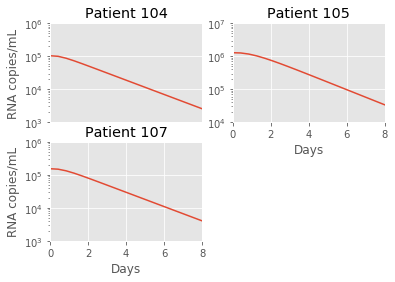

In [76]:
# Assign variables to constant values
k = 3.43e-8

V0_104 = 2*52e3; c_104 = 3.68 ; delta_104 = 0.5
V0_105 = 2*643e3; c_105 = 2.06; delta_105 = 0.53
V0_107 = 2*77e3; c_107 = 3.09; delta_107 = 0.5

# Use Equation 6 to determine viral loads for each patient
Vt_104 = V_t(V0_104, c_104, t, delta_104)
Vt_105 = V_t(V0_105, c_105, t, delta_105)
Vt_107 = V_t(V0_107, c_107, t, delta_107)

#Patient 104
plt.subplot(221)
plt.semilogy(t,Vt_104)
plt.xlim(0,8)
plt.ylim(1e3,1e6)
plt.xticks([])
plt.ylabel('RNA copies/mL')
plt.title('Patient 104')

#Patient 107
plt.subplot(223)
plt.semilogy(t,Vt_107)
plt.xlim(0,8)
plt.ylim(1e3,1e6)
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.title('Patient 107')

#Patient 105
plt.subplot(222)
plt.semilogy(t,Vt_105)
plt.xlim(0,8)
plt.ylim(1e4,1e7)
plt.xlabel('Days')
plt.title('Patient 105')

plt.show()

### (2) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [77]:
# Define function to solve equations 3, 4, and 5
def diffEQs(y, t, k, d, c, N, Ttot, Ti, eta):
    Ti, VI, VNI = y 
    dydt = [k*VI*(Ttot-Ti)-d*Ti, -c*VI+((1-eta)*N*d*Ti), N*d*Ti*eta-c*VNI]
    return dydt

#### ii. Use odeint to solve this system of equations numerically for patient 105.

Hint: For ease later, it may be helpful to make a function here that handles everything but takes in gnu.

In [78]:
# Assign values constant for all patients
k = 3.43e-8
eta = 1

# Assign values for each patient
Ttot_104, Ttot_105, Ttot_107 = 2e3, 11e3, 412e3
V0_104, V0_105, V0_107 = 52e3, 643e3, 77e3
d_104, d_105, d_107 = 0.50, 0.53, 0.50
c_104, c_105, c_107 = 3.68, 2.06, 3.09

# Calculate remaining values for each patient
Ti_104 = (Ttot_104*k*V0_104)/(d_104 + k*V0_104)
Ti_105 = (Ttot_105*k*V0_105)/(d_105 + k*V0_105)
Ti_107 = (Ttot_107*k*V0_107)/(d_107 + k*V0_107)

T0_104 = Ttot_104 - Ti_104
T0_105 = Ttot_105 - Ti_105
T0_107 = Ttot_107 - Ti_107

N_104 = (c_104*V0_104)/(d_104*Ti_104)
N_105 = (c_105*V0_105)/(d_105*Ti_105)
N_107 = (c_107*V0_107)/(d_107*Ti_107)

# Assign initial conditions for each patient
y0_104 = [Ti_104, V0_104, 0]
y0_105 = [Ti_105, V0_105, 0]
y0_107 = [Ti_107, V0_107, 0]

# Use odeint to solve for each patient
sol_104 = odeint(diffEQs, y0_104, t, args=(k, d_104, c_104, N_104, Ttot_104, Ti_104, eta))
sol_105 = odeint(diffEQs, y0_105, t, args=(k, d_105, c_105, N_105, Ttot_105, Ti_105, eta))
sol_107 = odeint(diffEQs, y0_107, t, args=(k, d_107, c_107, N_107, Ttot_107, Ti_107, eta))

#### iii. Reproduce the subpanels of Fig. 1 with this updated model.

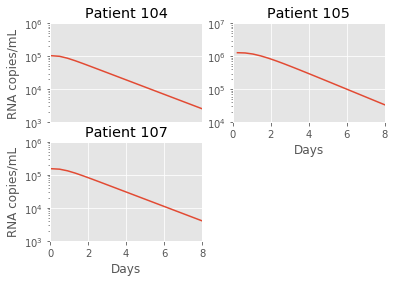

In [79]:
# Patient 104
v_104 = 2*(sol_104[:,1]+sol_104[:,2])
t_104 = np.linspace(1/12,8,20)
plt.subplot(221)
plt.semilogy(t_104, v_104)
plt.xlim(0,8)
plt.ylim(1e3,1e6)
plt.ylabel('RNA copies/mL')
plt.xticks([])
plt.title('Patient 104')

# Patient 107
v_107 = 2*(sol_107[:,1]+sol_107[:,2])
t_107 = np.linspace(1/12,8,20)
plt.subplot(223)
plt.semilogy(t_107, v_107)
plt.xlim(0,8)
plt.ylim(1e3,1e6)
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.title('Patient 107')

# Patient 105
v_105 = 2*(sol_105[:,1]+sol_105[:,2])
t_105 = np.linspace(1/4,8,20)
plt.subplot(222)
plt.semilogy(t_105, v_105)
plt.xlim(0,8)
plt.ylim(1e4,1e7)
plt.xlabel('Days')
plt.title('Patient 105')

plt.show()

#### iv. Are the results the same as in (1)?

Show evidence of your conclusion.

In [80]:
# Run 2-sample KS test
ks_2samp_104 = sp.stats.ks_2samp(Vt_104, v_104)
print('The p-value of the KS test for Patient 104 =', ks_2samp_104[1])

ks_2samp_105 = sp.stats.ks_2samp(Vt_105, v_105)
print('The p-value of the KS test for Patient 105 =', ks_2samp_105[1])

ks_2samp_107 = sp.stats.ks_2samp(Vt_107, v_107)
print('The p-value of the KS test for Patient 107 =', ks_2samp_107[1])

The p-value of the KS test for Patient 104 = 1.0
The p-value of the KS test for Patient 105 = 1.0
The p-value of the KS test for Patient 107 = 1.0


The p-values of the 2-sample KS tests round to 1.0 for each of the three patients. This tells us that the distributions between the experimental values and our predicted values are nearly identical.

### (3) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 days-1 and δ=0.5 days-1 as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

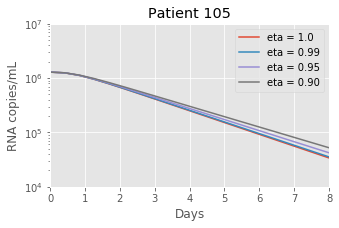

In [81]:
# Assign values constant for all patients
k = 3.43e-8

# Assign values for each patient
Ttot_new = Ttot_105
V0_new = V0_105
d_new = 0.50
c_new = 3.0
t_new = t_105

# Calculate remaining values for each patient
Ti_new = (Ttot_new*k*V0_new)/(d_new + k*V0_new)
T0_new = Ttot_new - Ti_new
N_new = (c_new*V0_new)/(d_new*Ti_new)

# Assign initial conditions for each patient
y0_new = [Ti_new, V0_new, 0]

# Set up different eta values and array for viral loads
etas = [1.0, 0.99, 0.95, 0.90]
load = np.zeros((20,4))
count = 0

# Iterate through different eta values
for eta in etas:
    sol = odeint(diffEQs, y0_new, t, args=(k, d_new, c_new, N_new, Ttot_new, Ti_new, eta))
    v_new = 2*(sol[:,1]+sol[:,2])
    load[:,count] = v_new
    count += 1

# Plot modified viral loads
plt.figure(figsize=(5,3))
plt.semilogy(t, load[:,0], label = 'eta = 1.0')
plt.semilogy(t, load[:,1], label = 'eta = 0.99')
plt.semilogy(t, load[:,2], label = 'eta = 0.95')
plt.semilogy(t, load[:,3], label = 'eta = 0.90')
plt.legend()
plt.xlim(0,8)
plt.ylim(1e4, 1e7)
plt.xlabel('Days')
plt.ylabel('RNA copies/mL')
plt.title('Patient 105')
plt.show()

The trends indicated by this graph follow the logic that as the efficiency of the drug decreases, the number of infectious viruses will increase correspondingly. 

#### (ii) Then, use the function scipy.optimize.leastsq to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss the consequences of an imperfect drug on clearance time estimates.

In [84]:
# Rename least squares function 
leastsq = sp.optimize.leastsq
t = np.linspace(0,8,20)
t_105 = np.linspace(0.25,8,20)
c = 3.0
d = 0.5
x = np.array([c,d])
cfit = np.zeros(4)
dfit = np.zeros(4)

Ti_105 = (Ttot_105*k*V0_105)/(d + k*V0_105)
y0_105 = [Ti_105, V0_105, 0]
vt_105 = V_t(2*V0_105, c, t_105, d)
  
def resids(x, t, data):
    pred = V_t(2*V0_105, x[0], t, x[1])
    return (pred - data)

# Use least squares to find c and delta with no time delay
print('Values without time delay:')
for i in range(len(etas)):
    fit = leastsq(resids, x, args=(t, load[:,i]))
    fit = fit[0]
    cfit[i] = fit[0]
    dfit[i] = fit[1]
    print('For eta =', etas[i], ', c =', fit[0], 'and delta =', fit[1],'.')
    
# Use least squares to find c and delta with time delay
print('\nValues with time delay for Patient 105:')
for i in range(len(etas)):
    fit = leastsq(resids, x, args=(t_105, load[:,i]))
    fit = fit[0]
    print('For eta =', etas[i], ', c =', fit[0], 'and delta =', fit[1],'.')

Values without time delay:
For eta = 1.0 , c = 2.99573111165 and delta = 0.499965605876 .
For eta = 0.99 , c = 2.9998043373 and delta = 0.493800068095 .
For eta = 0.95 , c = 3.01620160272 and delta = 0.469446583458 .
For eta = 0.9 , c = 3.03703433001 and delta = 0.43966909877 .

Values with time delay for Patient 105:
For eta = 1.0 , c = 2.05391166781 and delta = 0.545862681295 .
For eta = 0.99 , c = 2.05860394159 and delta = 0.538329584264 .
For eta = 0.95 , c = 2.07690955014 and delta = 0.508956480434 .
For eta = 0.9 , c = 2.09889252465 and delta = 0.473785279166 .


These values calculated with least squares correspond closely with the paper. The first set of values match the reported numbers for c and delta given in Note 12, which discusses the authors' fitting procedure. Additionally, the second set of value indicate that when the time delay for Patient 105 is taken into consideration, the c values are around 2.06, which was the c value reported for Patient 105. 

Both sets of values tell us that as the efficiency of the drug (eta) decreases, the rate constant for virion clearance increases, while the rate of loss of virus-producing cells decreases. These trends mean that an imperfect drug will result in longer clearance times. 

#### (iii) Examine the residual plots from your fits to determine whether or not there is a trend in the error associated with fitting these new curves.

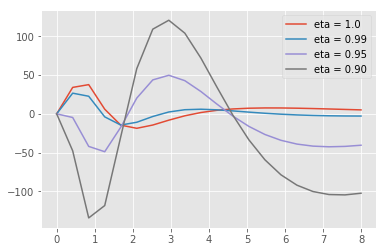

In [73]:
# Initialize array for residuals
resids_plot = np.zeros((len(t), len(etas)))

for i in range(len(etas)):
    x = np.array([cfit[i],dfit[i]])
    resids_plot[:,i] = resids(x, t, load[:,i])

# Plot residuals for each error value
plt.figure()
plt.plot(t,resids_plot[:,0], label = 'eta = 1.0')
plt.plot(t,resids_plot[:,1], label = 'eta = 0.99')
plt.plot(t,resids_plot[:,2], label = 'eta = 0.95')
plt.plot(t,resids_plot[:,3], label = 'eta = 0.90')
plt.legend()
plt.show()

The graph indicates that as the efficiency of the drug decreases, there is a larger fitting error. The smallest eta value seems to have the largest residual values. 

### (4) To determine the TCID50 one should estimate an infectivity coefficient.

To calculate the infectivity coefficient, estimate the ratio of VI(t=0) to the value of TCID50(t=0) for patient 105 from Perelson’s Figure 1. This coefficient acts as a conversion factor between the number of virions in the infectious pool, VI, and the TCID50, and is an indicator of the efficiency of the HIV-1 transmission.

Vi_0(t=0)/TCID50(t=0) = 522.7642276422764


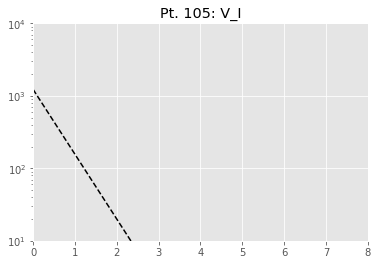

In [27]:
# TCID50 gives Amount of virus needed to infect 50% of cells

Ti = 0.5*Ttot_105
inf = 643e3/1.23e3
print('Vi_0(t=0)/TCID50(t=0) =', inf)

#Pt. 105 -- VI
VI_105 = 1.23e3*np.exp(-c_105*t)
plt.semilogy(t,VI_105, 'k--')
plt.xlim(0,8)
plt.ylim(1e1, 1e4)
plt.title('Pt. 105: V_I')
plt.show()